In [1]:
import tensorflow as tf
#https://medium.com/%E8%BB%9F%E9%AB%94%E4%B9%8B%E5%BF%83/%E9%81%A9%E5%90%88%E5%A4%A7%E9%87%8F%E8%B3%87%E6%96%99i-o%E7%9A%84%E5%84%B2%E5%AD%98%E6%A0%BC%E5%BC%8F-tfrecord%E7%B0%A1%E4%BB%8B%E8%88%87%E6%93%8D%E4%BD%9C%E6%95%99%E5%AD%B8-cd27e50d51ee

# mnist one example consists of 28*28 byte + 1 byte
# if _bytes_feature's args is alreaddy a list, no need to use []
def _image_feature(value):
    """"Returns a uint8(byte)_list from a byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _label_feature(value):
    """Returns a uint8(byte)_list from a byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [ ]:
""" transfer dataset to tfrecord method"""
# the whole image is a byte feature, not a byte list
import os
import struct                                                                   
import numpy as np                                                              
import matplotlib.pyplot as plt                                                 
from PIL import Image
from queue import PriorityQueue as PQ
def serialize_example(_label, _image):
    feature = {
        "label": _label_feature(_label),
        "image": _image_feature(_image),
        }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString() 

images_file_name = './train-images.idx3-ubyte'
labels_file_name = './train-labels.idx1-ubyte'
images_dir = './mnist jpeg/'
oft_file_name='mnist-sparse_padded_BFD-offset_table'
tfr_file_name='mnist_sparse_padded_BFD.tfrecords'
mnist_images=open(images_file_name,'rb')
mnist_labels=open(labels_file_name,'rb')
# skip header file
_=mnist_images.read(16)
_=mnist_labels.read(8)

# data
# build offset_table while writing TFRecords, int64 for offset of each instance, e.g. offset of instance #100 is 100*8B=800B
# byte is little endian
offset_table=open(oft_file_name,'wb') 

# BFD algorithm, input: all instances; output: BFD order (e.g. [0,2,1] means in rewrited dataset the order is ins #0 #2 #1)
# items contains [w,idx] of each item, remain_w in front for sorting
# bins contains idx of instances inside it (e.g. [[0,1,3],[2,4,5]] means bin1 has ins #0 #1 #3)
# bins_remain_w contains [remain_w,bin_idx] of each bin, remain_w in front for sorting

# bins contains [remain_w,[item_idx]]
items=[]

#bins_remain_w=[]

# pre BFD
# know the length of each instance
for i in range (60000):
    len_record=0
    if(i%4000==0):
        print(i,end=' ')
    with open(images_dir+str(i)+'.jpg','rb') as f:
        buf=mnist_labels.read(1)
        _label=buf
        img_bytes=f.read()
        serialized_example = serialize_example(_label, img_bytes)
        # 16B metadata
        len_record=len(serialized_example)+16        
    item=[len_record,i]
    items.append(item)

# BFD step 1: sort all items, heaviest first
items.sort()
items.reverse()
mnist_images.close()
mnist_labels.close()
offset_table.close()

0 4000 8000 12000 

In [ ]:
import time
# BFD step 2: For each item, find a bin with the maximum load into which the item can fit, if any.
#TODO: O(N^2) implementation, use binary search to achieve O(NlogN), 手刻可能比較快
# initialize first bin
bins=[]
A=[4096,[]]
bins.append(A)
c=0
start_t=time.time()
for item in items:
    
    #print("processing item ",item[1])
    
    c+=1
    if(c%2000==0):
        end_t=time.time()
        print(c,end_t-start_t)
        start_t=time.time()
    no_bin=True
    for B in bins:
        # if B has enough space, put item into B, break
        if B[0]>=item[0]:
            B[0]-=item[0]
            B[1].append(item[1])
            no_bin=False
            break
    # if no bins is big enough for item, open a new one
    if no_bin:
        A=[4096-item[0],[item[1]]]        
        bins.append(A)
    bins.sort()
c=0
for B in bins:
    #print(len(B[1]))
    c+=len(B[1])
print(c)
# If such a bin is found, the new item is placed inside it.
# Otherwise, a new bin is opened and the coming item is placed inside it.

b'\x07'


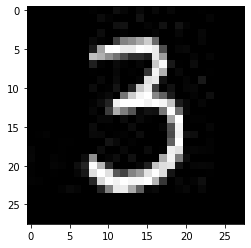

b'\x01'


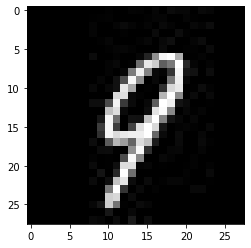

b'\x03'


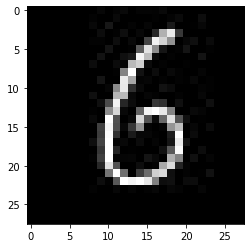

b'\t'


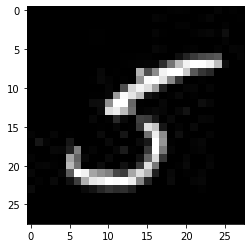

b'\x02'


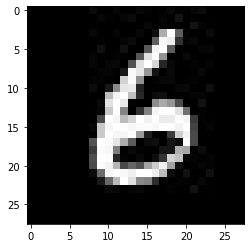

b'\x01'


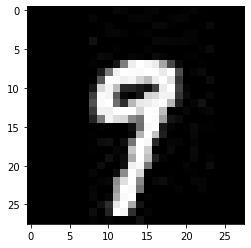

b'\t'


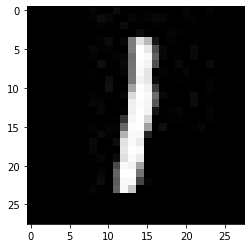

b'\t'


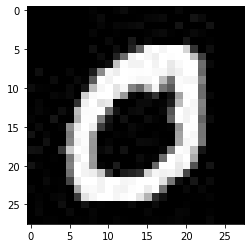

b'\x08'


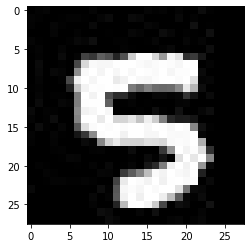

4000 offset= 2691072
8000 offset= 5417852
12000 offset= 8118272
16000 offset= 10784152
20000 offset= 13303808
24000 offset= 15878921
28000 offset= 18519318


KeyboardInterrupt: 

In [7]:
# write as BFD order
# for each bin, write each instance of bin[1]

mnist_images=open(images_file_name,'rb')
mnist_labels=open(labels_file_name,'rb')
offset_table=open(oft_file_name,'wb')
# skip header file
_=mnist_images.read(16)
_=mnist_labels.read(8)
with tf.io.TFRecordWriter(tfr_file_name) as writer:
    # page size=4KB, padding to write to another page if the next instance exceeds the page
    
    """padding needs to ne slightly modified: because padded record needs at least 16B, 
    instead of see if after_ptr exceeds, see if after_ptr+16 exceeds """
    cur_page=0
    c=0
    for B in bins:
        for i in B[1]:
            # current tfr file ptr = current_filesize
            with open(images_dir+str(i)+'.jpg','rb') as f:
                c+=1
                mnist_labels.seek(i,0)
                buf=mnist_labels.read(1)                
                _label=buf
                img_bytes=f.read()
                
                
                if(c<10):
                    print(_label)
                    image=tf.io.decode_jpeg(img_bytes)
                    plt.imshow(np.asarray(image).reshape((28,28)),cmap = plt.cm.gray)                                        
                    plt.show()
                
                current_filesize=os.path.getsize(tfr_file_name)
                # test if exceeds or not, other 3 columns: 16B
                cur_page=int(current_filesize/4096)
                serialized_example = serialize_example(_label, img_bytes)
                calc_new_filesize=current_filesize+len(serialized_example)+16+16
                calc_new_page=int(calc_new_filesize/4096)            

                if(calc_new_page>cur_page):
                    # if exceeds: padding until reaching new page
                    #TODO: the pad still needs 16B metadata
                    pad_len=calc_new_page*4096-current_filesize
                    #print("before pad:",current_filesize)
                    pad=b''
                    if(pad_len-16>0):                    
                        for _ in range (pad_len-16):
                            pad+=b'0'
                        #print("len(pad)=",len(pad))
                        writer.write(pad)
                        #current_filesize=os.path.getsize("mnist_sparse_padded.tfrecords") 
                        #print("after pad",current_filesize)
                    else:
                        print("error")
                current_filesize=os.path.getsize(tfr_file_name) 
                #print("after after pad",current_filesize)
                
                
                if(c%4000==0):
                    print(c,end=' ')
                    print("offset=",current_filesize)
                offset_table.write(current_filesize.to_bytes(8, byteorder = 'little')) 
                writer.write(serialized_example)
offset_table.close()
mnist_images.close()
mnist_labels.close()

label= b'\t'


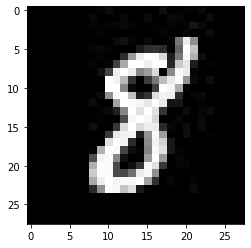

label= b'\x05'


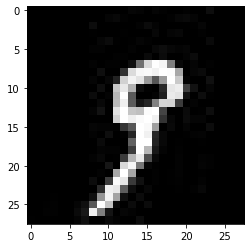

In [25]:
""" standard way to iterate tfr, to make sure the tfr format is right """

dataset = tf.data.TFRecordDataset(tfr_file_name)

image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.string),
    # var len is different
    'image': tf.io.FixedLenFeature([],tf.string),
}

def _parse_function(example_proto):
    serialized_example = tf.io.parse_single_example(example_proto, image_feature_description)
    return serialized_example


for idx, features in enumerate(dataset):
    parsed_features = _parse_function(features)
    print("label=",parsed_features['label'].numpy())    
    image=tf.io.decode_jpeg(parsed_features['image'])
    plt.imshow(np.asarray(image).reshape((28,28)),cmap = plt.cm.gray)                                        
    plt.show()
    
    if idx>=1:
        break

In [52]:
"""offset table read test"""

oft=open(oft_file_name,'rb')
idx=5
for i in range (60000):
    
    tmp=oft.read(8)
    #print(tmp)
    if(i%4000==0):
        length=struct.unpack("<Q",tmp)
        print(length[0])
        
oft.close()

0
2672383
5374539
8053940
10661888
13181595
15756600
18397086
21055369
23717478
26399802
29080008
31757528
34438147
37120997


In [8]:
""" the actual read() function """

def sparse_random_read(binfile, oft, idx):
    # read offset, 8B per instance
    #TODO: oft should be loaded to mem
    oft.seek(idx*8,0)
    tmp=oft.read(8)
    offset=struct.unpack("<Q",tmp)[0]
    print("offset=",offset)
    
    # read data length
    binfile.seek(offset,0)
    tmp=binfile.read(8)
    length=struct.unpack("<Q",tmp)[0]
    print("length=",length)
    # we already read first 8B
    record_l_from_col2=length+8
    
    # random read
    tmp=binfile.read(record_l_from_col2)
    r_data=tmp[4:-4]

    # deserialize data
    parsed_features = _parse_function(r_data)
    return parsed_features
    
    

offset= 0
length= 582
tf.Tensor(b'\x05', shape=(), dtype=string)


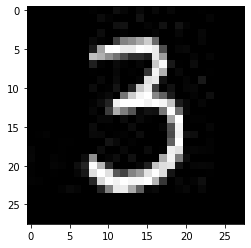

In [11]:
""" test read() function """

binfile=open(tfr_file_name,'rb')
oftfile=open(oft_file_name,'rb')
parsed_feature=sparse_random_read(binfile,oftfile, 0)
image=tf.io.decode_jpeg(parsed_feature['image'])
print(parsed_feature['label'])
np_image=np.frombuffer(image, dtype='>B').astype(np.uint8)
plt.imshow(np.asarray(np_image).reshape((28,28)),cmap = plt.cm.gray)                                        
plt.show()

In [10]:
oft=open(oft_file_name,'rb')
page_aligned_indices = []
idx=0
for idx in range(60000):
    oft.seek(idx*8,0)
    tmp=oft.read(8)
    #print(idx)
    offset=struct.unpack("<Q",tmp)[0]
    if(offset % 4096 == 0):
        page_aligned_indices.append(idx)

print(page_aligned_indices)

[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 67, 73, 79, 86, 92, 99, 105, 111, 117, 123, 129, 136, 143, 149, 155, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 229, 235, 242, 248, 254, 260, 267, 273, 279, 286, 292, 298, 305, 311, 317, 323, 329, 335, 341, 347, 354, 360, 366, 372, 378, 384, 390, 396, 402, 408, 414, 421, 427, 433, 439, 445, 451, 457, 463, 469, 475, 482, 488, 494, 500, 506, 512, 519, 525, 531, 537, 543, 549, 555, 561, 567, 573, 579, 586, 592, 599, 605, 611, 617, 624, 630, 636, 641, 647, 653, 659, 666, 672, 678, 684, 690, 696, 702, 709, 716, 721, 727, 734, 740, 746, 752, 758, 764, 770, 776, 783, 789, 795, 801, 807, 814, 821, 826, 831, 836, 841, 847, 853, 859, 865, 871, 877, 883, 889, 896, 903, 909, 916, 922, 928, 934, 940, 947, 953, 959, 965, 971, 977, 984, 990, 996, 1002, 1008, 1014, 1021, 1027, 1034, 1040, 1046, 1052, 1058, 1064, 1070, 1076, 1081, 1086, 1092, 1098, 1104, 1110, 1117, 1123, 1129, 1135, 1141, 1147, 1153, 1159, 1165, 1171, 1177, 1183, 1189, 1195, 1200,

In [19]:
mnist_labels=open(labels_file_name,'rb')
print(mnist_labels.read(1))
print(mnist_labels.read(1))
print(mnist_labels.read(1))
print(mnist_labels.read(1))
print(mnist_labels.read(1))
print(mnist_labels.read(1))
mnist_labels.close()

b'\x00'
b'\x00'
b'\x08'
b'\x01'
b'\x00'
b'\x00'


In [6]:
mnist_labels=open(labels_file_name,'rb')
_=mnist_labels.read(8)
for i in range(60):
    print(mnist_labels.read(1))
mnist_labels.close()

b'\x05'
b'\x00'
b'\x04'
b'\x01'
b'\t'
b'\x02'
b'\x01'
b'\x03'
b'\x01'
b'\x04'
b'\x03'
b'\x05'
b'\x03'
b'\x06'
b'\x01'
b'\x07'
b'\x02'
b'\x08'
b'\x06'
b'\t'
b'\x04'
b'\x00'
b'\t'
b'\x01'
b'\x01'
b'\x02'
b'\x04'
b'\x03'
b'\x02'
b'\x07'
b'\x03'
b'\x08'
b'\x06'
b'\t'
b'\x00'
b'\x05'
b'\x06'
b'\x00'
b'\x07'
b'\x06'
b'\x01'
b'\x08'
b'\x07'
b'\t'
b'\x03'
b'\t'
b'\x08'
b'\x05'
b'\t'
b'\x03'
b'\x03'
b'\x00'
b'\x07'
b'\x04'
b'\t'
b'\x08'
b'\x00'
b'\t'
b'\x04'
b'\x01'
